In [2]:
N = 2
label_dict = {"cats": 0, "dogs": 1}
class_dict = {0: "cats", 1: "dogs"}

In [9]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)


class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        writer.add_scalar("val_loss", val_loss, epoch)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

In [10]:
train()

data processing...
train...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]E:\python0000\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  3%|##7                                                                                | 1/30 [00:03<01:42,  3.52s/it]

Epoch 000 train_loss 0.69046 val_loss 0.71216


  7%|#####5                                                                             | 2/30 [00:06<01:37,  3.48s/it]

Epoch 001 train_loss 0.66209 val_loss 0.73067


 10%|########3                                                                          | 3/30 [00:10<01:33,  3.45s/it]

Epoch 002 train_loss 0.63213 val_loss 0.72808


 13%|###########                                                                        | 4/30 [00:13<01:29,  3.44s/it]

Epoch 003 train_loss 0.60853 val_loss 0.60445


 17%|#############8                                                                     | 5/30 [00:17<01:25,  3.42s/it]

Epoch 004 train_loss 0.58692 val_loss 0.59712


 20%|################6                                                                  | 6/30 [00:20<01:22,  3.43s/it]

Epoch 005 train_loss 0.56180 val_loss 0.62718


 23%|###################3                                                               | 7/30 [00:24<01:18,  3.43s/it]

Epoch 006 train_loss 0.53612 val_loss 0.54648


 27%|######################1                                                            | 8/30 [00:27<01:15,  3.43s/it]

Epoch 007 train_loss 0.53106 val_loss 0.59767


 30%|########################9                                                          | 9/30 [00:31<01:12,  3.45s/it]

Epoch 008 train_loss 0.50973 val_loss 0.58814


 33%|###########################3                                                      | 10/30 [00:34<01:09,  3.49s/it]

Epoch 009 train_loss 0.50987 val_loss 0.57595


 37%|##############################                                                    | 11/30 [00:38<01:06,  3.51s/it]

Epoch 010 train_loss 0.51050 val_loss 0.60955


 40%|################################8                                                 | 12/30 [00:41<01:02,  3.49s/it]

Epoch 011 train_loss 0.48619 val_loss 0.58673


 43%|###################################5                                              | 13/30 [00:45<00:59,  3.48s/it]

Epoch 012 train_loss 0.48943 val_loss 0.54805


 47%|######################################2                                           | 14/30 [00:48<00:55,  3.47s/it]

Epoch 013 train_loss 0.47165 val_loss 0.73873


 50%|#########################################                                         | 15/30 [00:51<00:51,  3.45s/it]

Epoch 014 train_loss 0.46651 val_loss 0.56590


 53%|###########################################7                                      | 16/30 [00:55<00:48,  3.44s/it]

Epoch 015 train_loss 0.46169 val_loss 0.61575


 57%|##############################################4                                   | 17/30 [00:58<00:44,  3.44s/it]

Epoch 016 train_loss 0.44308 val_loss 0.55801


 60%|#################################################1                                | 18/30 [01:02<00:41,  3.45s/it]

Epoch 017 train_loss 0.42593 val_loss 0.49529


 63%|###################################################9                              | 19/30 [01:05<00:38,  3.46s/it]

Epoch 018 train_loss 0.42742 val_loss 0.63617


 67%|######################################################6                           | 20/30 [01:09<00:34,  3.45s/it]

Epoch 019 train_loss 0.42415 val_loss 0.56927


 70%|#########################################################4                        | 21/30 [01:12<00:31,  3.44s/it]

Epoch 020 train_loss 0.42253 val_loss 0.52546


 73%|############################################################1                     | 22/30 [01:15<00:27,  3.43s/it]

Epoch 021 train_loss 0.41529 val_loss 0.58684


 77%|##############################################################8                   | 23/30 [01:19<00:24,  3.43s/it]

Epoch 022 train_loss 0.40798 val_loss 0.54459


 80%|#################################################################6                | 24/30 [01:22<00:20,  3.42s/it]

Epoch 023 train_loss 0.40838 val_loss 0.55378


 83%|####################################################################3             | 25/30 [01:26<00:17,  3.42s/it]

Epoch 024 train_loss 0.39766 val_loss 0.57919


 87%|#######################################################################           | 26/30 [01:29<00:13,  3.41s/it]

Epoch 025 train_loss 0.41157 val_loss 0.53434


 90%|#########################################################################8        | 27/30 [01:33<00:10,  3.45s/it]

Epoch 026 train_loss 0.41040 val_loss 0.53119


 93%|############################################################################5     | 28/30 [01:36<00:06,  3.45s/it]

Epoch 027 train_loss 0.39680 val_loss 0.62311


 97%|###############################################################################2  | 29/30 [01:40<00:03,  3.44s/it]

Epoch 028 train_loss 0.37875 val_loss 0.51518


100%|##################################################################################| 30/30 [01:43<00:00,  3.45s/it]
2024-11-21 18:33:24.509 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 107.22829604148865 s


Epoch 029 train_loss 0.38028 val_loss 0.52837


In [25]:
test()

data processing...


C:\Users\Chexaville\AppData\Local\Temp\ipykernel_11440\3471500720.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), Fa

Accuracy:88%


In [15]:
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms

In [35]:
model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = "data/testing_data/dogs/dog.1037.jpg"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

dogs


C:\Users\Chexaville\AppData\Local\Temp\ipykernel_11440\2377548012.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), Fals

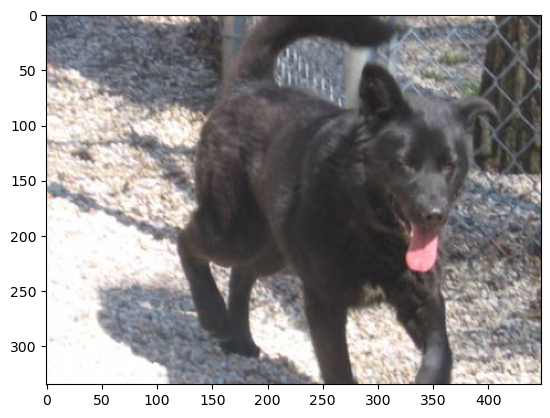

In [36]:
plt.imshow(img, cmap='gray')
plt.show()